# description

train.csv — личные записи примерно двух третей (~8700) пассажиров, которые будут использоваться в качестве обучающих данных.

PassengerId - Уникальный идентификатор для каждого пассажира. Каждый идентификатор принимает форму gggg_pp, где gggg указывает группу, с которой путешествует пассажир, и pp является их номером в группе. Люди в группе часто являются членами семьи, но не всегда.

HomePlanet - Планета, с которой вылетел пассажир, как правило, планета его постоянного проживания.

CryoSleep - Указывает, решил ли пассажир быть переведен в режим анабиоза на время рейса. Пассажиры, находящиеся в криосонном состоянии, находятся в своих каютах.

Cabin - Номер каюты, в которой находится пассажир. Принимает вид deck/num/side, где side может быть либо P за левый , либо S за правый борт.

Destination - Планета, на которую будет высаживаться пассажир.

Age - Возраст пассажира.

VIP - Оплатил ли пассажир специальное VIP-обслуживание во время рейса.

RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Сумма, которую пассажир выставил в счет за каждое из многочисленных роскошных удобств космического корабля Титаник.

Name - Имя и фамилия пассажира.

Transported - Был ли пассажир перенесён в другое измерение. Это цель, столбец, который вы пытаетесь предсказать.

# load data

In [1]:
!kaggle competitions download -c spaceship-titanic

spaceship-titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
import zipfile

Dataset = "spaceship-titanic.zip"

# Will unzip the files so that you can see them..
with zipfile.ZipFile(Dataset,"r") as z:
    z.extractall(".")

# imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# clean data

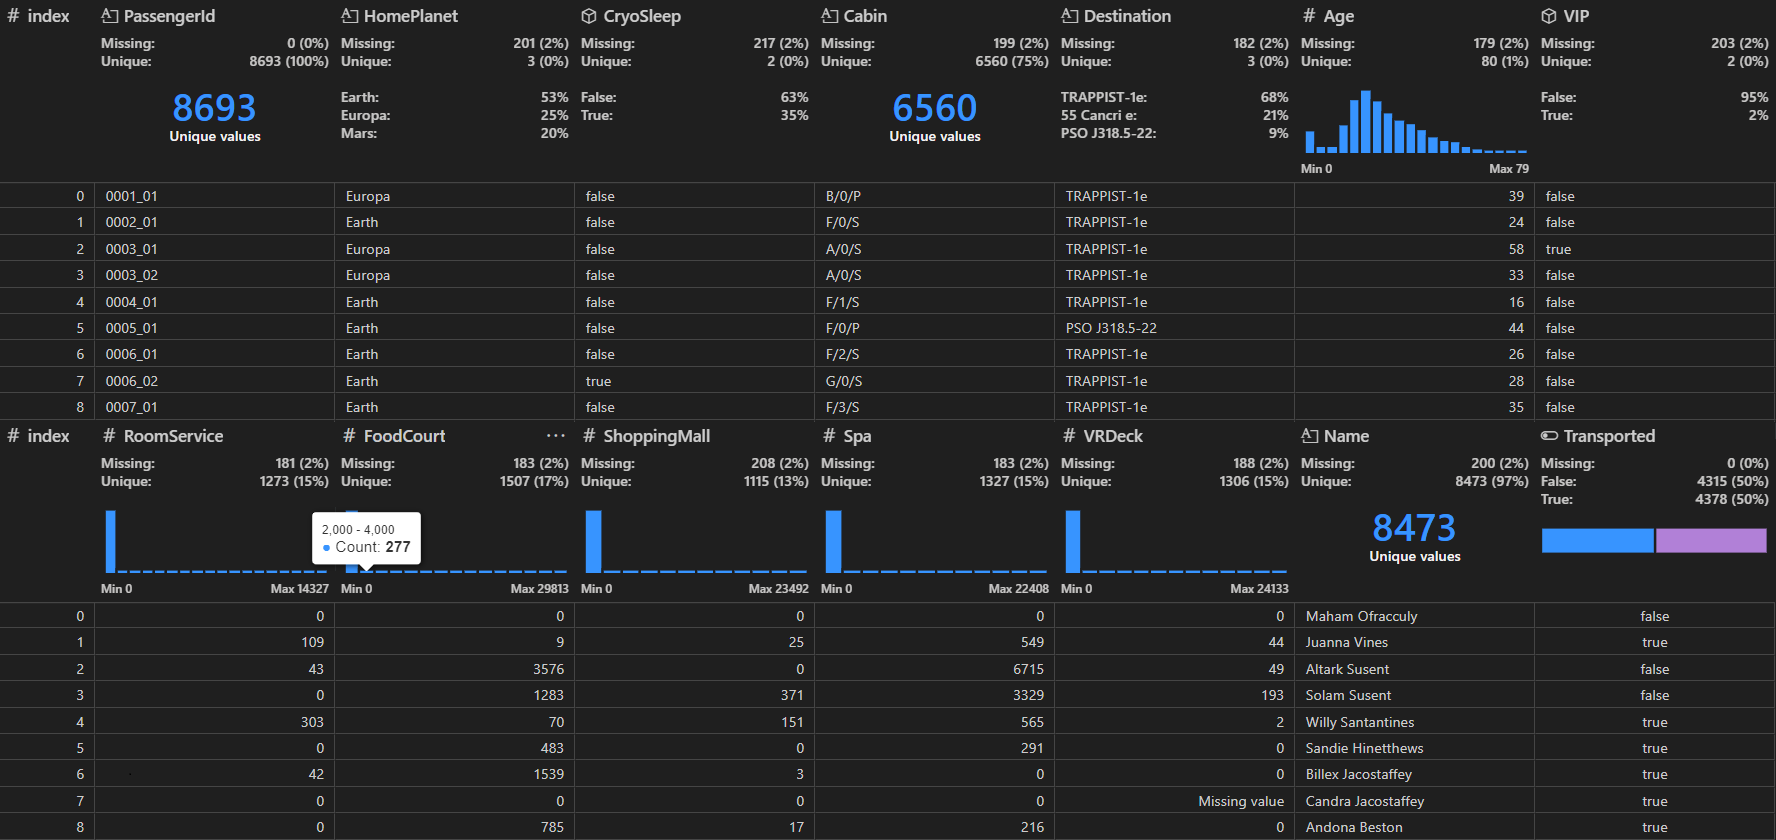

In [4]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
Image('train_df_stats.png')

In [5]:
def clean_data(df):
    age_bins = [-1, 5, 20, 30, 40, 50, 60, 100]
    cabin_bins = [-1, 300, 600, 900, 1200, 1500, 1800, 2100]

    df = df.fillna({'CryoSleep': df['CryoSleep'].mode()[0]})
    df = df.fillna({'VIP': df['VIP'].mode()[0]})
    df = df.fillna({'RoomService': int(df['RoomService'].median())})
    df = df.fillna({'FoodCourt': int(df['FoodCourt'].median())})
    df = df.fillna({'ShoppingMall': int(df['ShoppingMall'].median())})
    df = df.fillna({'Spa': int(df['Spa'].median())})
    df = df.fillna({'VRDeck': int(df['VRDeck'].median())})
    df = df.fillna({'Age': df['Age'].median()})
    df['HomePlanet'] = df['HomePlanet'].fillna('Unknown_Home')
    df['Destination'] = df['Destination'].fillna('Unknown_Destination')
    df['Cabin'] = df['Cabin'].fillna('Unknown_Deck/0/Unknown_Side')

    df['TotalSpent'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    df['AverageSpent'] = round(df['TotalSpent']/5, 0)
    #df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
    
    df['PassengerGroup'] = df['PassengerId'].apply(lambda x: x[:4]).astype(int)
    df['GroupCount'] = df.groupby('PassengerGroup')['PassengerGroup'].transform('count')

    df['CabinDeck'] = df['Cabin'].astype(str).str.split('/').apply(lambda x : x[0] if len(x)==3 else 'Unlisted')
    df['CabinNum'] = df['Cabin'].astype(str).str.split('/').apply(lambda x : x[1] if len(x)==3 else 'Unlisted')
    df['CabinSide'] = df['Cabin'].astype(str).str.split('/').apply(lambda x : x[2] if len(x)==3 else 'Unlisted')
    df['CabinCategory'] = pd.cut(df['CabinNum'].astype(int),
                                bins=cabin_bins,
                                labels=['range1', 'range2', 'range3', 'range4', 'range5', 'range6', 'range7'])
    
    df['AgeCategory'] = pd.cut(df['Age'],
                                bins=age_bins,
                                labels=['Infant','Teen','20s', '30s', '40s', '50s', 'Elderly'])
    
    df['Name'] = df['Name'].fillna('Unlisted_FN Unlisted_LN')
    df['LastName'] = df['Name'].astype(str).str.split(' ').apply(lambda x: x[1] if len(x) == 2 else 'Unlisted')
    df['FamilyCount'] = df.groupby('LastName')['LastName'].transform('count')

    df['VIP'] = df['VIP'].astype(int)
    df['CryoSleep'] = df['CryoSleep'].astype(int)
    
    try:
        df['Transported'] = df['Transported'].astype(int)
    except:
        pass

    df['AgeCategory'] = df['AgeCategory'].map({'Infant':0,'Teen':1,'20s':2,'30s':3,'40s':4,'50s':5,'Elderly':6})
    df['CabinCategory'] = df['CabinCategory'].map({'range1':0,'range2':1,'range3':2,'range4':3,'range5':4,'range6':5,'range7':6})
    df['HomePlanet'] = df['HomePlanet'].map({'Europa':1,'Earth':2,'Mars':3,'Unknown_Home':4})
    df['Destination'] = df['Destination'].map({'TRAPPIST-1e':1,'55 Cancri e':2,'PSO J318.5-22':3,'Unknown_Destination':4})

    df['CabinDeck'] = df['CabinDeck'].map({'B':1,'F':2,'A':3,'G':4,'T':4,'E':5,'D':6,'C':7,'Unknown_Deck':8})
    df['CabinSide'] = df['CabinSide'].map({'P':1,'S':2,'Unknown_Side':3})



    df = df.drop(columns=['PassengerId','Cabin','Age','Name','CabinNum','PassengerGroup','LastName']) 

    return df

df_train_clean = clean_data(df_train.copy())
df_test_clean = clean_data(df_test.copy())
df_train_clean.head()


,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,TotalSpent,AverageSpent,GroupCount,CabinDeck,CabinSide,CabinCategory,AgeCategory,FamilyCount
0,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,1,1,0,3,1
1,2,0,1,0,109.0,9.0,25.0,549.0,44.0,1,736.0,147.0,1,2,2,0,2,4
2,1,0,1,1,43.0,3576.0,0.0,6715.0,49.0,0,10383.0,2077.0,2,3,2,0,5,6
3,1,0,1,0,0.0,1283.0,371.0,3329.0,193.0,0,5176.0,1035.0,2,3,2,0,3,6
4,2,0,1,0,303.0,70.0,151.0,565.0,2.0,1,1091.0,218.0,1,2,2,0,1,6


In [6]:
X = df_train_clean.drop(['Transported'], axis=1)
y = df_train_clean.Transported

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
X_test = df_test_clean
X_test

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,TotalSpent,AverageSpent,GroupCount,CabinDeck,CabinSide,CabinCategory,AgeCategory,FamilyCount
0,2,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4,2,0,2,4
1,2,0,1,0,0.0,9.0,0.0,2823.0,0.0,2832.0,566.0,1,2,2,0,1,1
2,1,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,7,2,0,3,1
3,1,0,1,0,0.0,6652.0,0.0,181.0,585.0,7418.0,1484.0,1,7,2,0,3,1
4,2,0,1,0,10.0,0.0,635.0,0.0,0.0,645.0,129.0,1,2,2,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,2,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,4,2,4,3,4
4273,2,0,1,0,0.0,847.0,17.0,10.0,144.0,1018.0,204.0,1,8,3,0,4,2
4274,3,1,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,6,1,0,2,4
4275,1,0,4,0,0.0,2680.0,0.0,0.0,523.0,3203.0,641.0,1,6,1,0,2,5


In [73]:
rf = RandomForestClassifier(random_state=42)

parameters = {
    'n_estimators': [37],
    'max_depth': [11],
}

grid_search_cv_rf = GridSearchCV(rf, parameters)
grid_search_cv_rf.fit(X_train, y_train)
grid_search_cv_rf.best_params_

rf_train = grid_search_cv_rf.score(X_train,y_train)
rf_valid = grid_search_cv_rf.score(X_valid,y_valid)
print('Train accuracy = {}'.format(rf_train))
print('Test accuracy = {}'.format(rf_valid))


Train accuracy = 0.8927236123094622
Test accuracy = 0.7935595169637722


In [74]:
submission = pd.DataFrame({
        "PassengerId": df_test['PassengerId'],
        "Transported": grid_search_cv_rf.predict(X_test).astype(bool)
    })
submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [75]:
submission.to_csv('submission.csv', index=False)

In [76]:
!kaggle competitions submit -c spaceship-titanic -m "Submition Base Random Forest" -f submission.csv

Successfully submitted to Spaceship Titanic



  0%|          | 0.00/60.5k [00:00<?, ?B/s]
 13%|█▎        | 8.00k/60.5k [00:01<00:07, 7.01kB/s]
100%|██████████| 60.5k/60.5k [00:02<00:00, 25.8kB/s]
